В качестве датасета я выбрал Stroke Prediction Dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-datase

Вопрос медицины стоит очень остро, MachineLearning является топ кандидатом для решения задачи определения возможности инсульта у людей по некоторым признакам.

Это задача бинарной классификации с двумя классами: инсульт вероятен, и инсульт не вероятен.

In [24]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.utils import resample
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder, OneHotEncoder, Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    LogisticRegression as skLogisticRegression,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
    roc_curve,
    plot_confusion_matrix,
)

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

Информация о признаках:

1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not

Задача:

1. реализовать следующие алгоритмы машинного обучения: Linear/ Logistic Regression, SVM, KNN, Naive Bayes в отдельных классах 
2.  Данные классы должны наследоваться от BaseEstimator и  ClassifierMixin, иметь методы fit и predict (подробнее: https://scikit-learn.org/stable/developers/develop.html)
3. Вы должны организовать весь процесс предобработки, обучения и тестирования с помощью Pipeline (подробнее: https://scikit-learn.org/stable/modules/compose.html)
4. Вы должны настроить гиперпараметры моделей с помощью кросс валидации (GridSearchCV,RandomSearchCV, подробнее здесь: https://scikit-learn.org/stable/modules/grid_search.html), вывести и сохранить эти гиперпараметры в файл, вместе с обученными моделями
5. Проделать аналогично с коробочными решениями
6. Для каждой модели получить оценки метрик:Confusion Matrix,  Accuracy, Recall, Precision, ROC_AUC curve (подробнее: Hands on machine learning with python and scikit learn chapter 3, mlcourse.ai, https://ml-handbook.ru/chapters/model_evaluation/intro)
7. Проанализировать полученные результаты и сделать выводы о применимости моделей
8. Загрузить полученные гиперпараметры модели и обученные модели в формате pickle  на гит вместе с jupyter notebook ваших экспериментов

In [3]:
if 'id' in data:
    data = data.drop('id', axis=1)
data['bmi'].fillna(data['bmi'].mean(), inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [4]:

# cols = data.columns.tolist()
# categories= []
# for col in cols:
#     if data[col].dtype == 'object':
#         categories.append(data[col].unique().tolist())
# print(categories)
# ct = ColumnTransformer(transformers=[
#       ('categories', OneHotEncoder(sparse=False), [0, 4, 5, 6, 9]),
#       ('normalizer', StandardScaler(), [1, 7, 8])
# ])
# dtrain = ct.fit_transform(data)
# data.shape, dtrain.shape,
# dtrain.categories_

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data.drop(columns='stroke'), data['stroke'], train_size=0.8, random_state=42, shuffle=True
)

In [6]:
df = train_data.copy()
df['stroke'] = train_labels

df_majority = df[df['stroke']==0]
df_minority = df[df['stroke']==1]
 
df_minority_upsampled = resample(
    df_minority, replace=True, n_samples=len(df_minority) * 2, random_state=123
)
# df_majority_downsampled = resample(
#     df_majority, replace=True, n_samples=len(df_majority) - 500, random_state=123
# )

train_df = pd.concat([df_minority_upsampled, df_majority])

train_df.stroke.value_counts()

0    3901
1     374
Name: stroke, dtype: int64

In [7]:
train_data, train_labels = train_df.drop(columns='stroke'), train_df['stroke']

Импорты:

In [8]:
import itertools
import warnings
import pickle

warnings.filterwarnings("ignore", category=FutureWarning) 

Вспомогательные функции:

In [9]:
def batches(X, y, size):
    for pos in range(len(X), size):
        yield X[pos:pos + size], y[pos:pos + size]

def sigmoid(vec: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-vec))

Реализуем Logistic Regression:

In [10]:
class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(
        self, 
        lr: float = 1e-3,
        batch_size: int = 100,
        max_iter: int = 200,
        C: float = 0.1,
        bound: float = 0.5,
    ):
        self.lr = lr
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.C = C
        self.bound = bound

    def _fit(self, X, y):
        self.X_, self.y_ = X, y
        w, b = np.random.normal(size=(X.shape[1], )), 0.0
        for _, bX, by in itertools.product(
            range(self.max_iter), batches(X, y, self.batch_size)
        ):
            logor = sigmoid(bX @ w + b)
            w -= (self.lr * bX.T @ (logor - by) + w / self.C) / self.batch_size
            b -= self.lr * np.sum(logor - by) / self.batch_size
        self.w, self.b = w, b
        return self

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        return self._fit(X, y)

    def decision_function(self, X):
        check_is_fitted(self)
        X =  check_array(X)
        X = X @ self.w + self.b
        # print('decision.shape:', X.shape)
        return X
    
    def predict_proba(self, X):
        return sigmoid(self.decision_function(X))

    def predict(self, X):
        vec = self.predict_proba(X)
        # print('vec head:', vec[:5])
        res = np.where(vec > self.bound, 1, 0 )
        # print('res head: ', res[:5])
        return res

Создадим pipeline и сделаем GridSearchCV для перебора гиперпараметров:

In [11]:
model = GridSearchCV(
    refit=True,
    scoring='roc_auc',
    verbose=3,
    estimator=make_pipeline(
        ColumnTransformer(transformers=[
            ('categories', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 4, 5, 6, 9]),
            ('normalizer', StandardScaler(), [1, 7, 8])
        ]),
        PowerTransformer(standardize=True),
        LogisticRegression(),
    ),
    param_grid={
        'logisticregression__max_iter': [100],
        'logisticregression__bound': [0.5, 0.7, 0.9],
        'logisticregression__lr': [1e-04, 1e-03, 1e-02, 1e-01],
        'logisticregression__C': [1.0, 5.0, 7.5, 10.0],
        'logisticregression__batch_size': [64],
    },
    n_jobs=-1,
)

In [12]:
orig_model = GridSearchCV(
    refit=True,
    scoring='roc_auc',
    verbose=0,
    estimator=make_pipeline(
        ColumnTransformer(transformers=[
            ('categories', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 4, 5, 6, 9]),
            ('normalizer', StandardScaler(), [1, 7, 8])
        ]),
        PowerTransformer(standardize=True),
        skLogisticRegression(),
    ),
    param_grid={
        'logisticregression__max_iter': [100],
        'logisticregression__class_weight': ['balanced'],
        'logisticregression__tol': [1e-04, 1e-03, 1e-02],
        'logisticregression__C': [1e-1, 1.0, 10.0],
    },
    n_jobs=1,
)

In [14]:
model.fit(train_data, train_labels)
with open('logreg_model.pkl', 'wb') as file:
    pickle.dump(model.best_estimator_, file)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [ ]:
model.best_params_

{'logisticregression__C': 10.0,
 'logisticregression__batch_size': 64,
 'logisticregression__bound': 0.9,
 'logisticregression__lr': 0.01,
 'logisticregression__max_iter': 100}

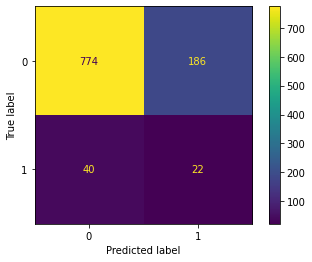

In [ ]:
plot_confusion_matrix(estimator=model, X=test_data, y_true=test_labels)

Посмотрим на алгоритм из коробки:

In [ ]:
orig_model.fit(train_data, train_labels)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('categories',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         [0, 4,
                                                                          5, 6,
                                                                          9]),
                                                                        ('normalizer',
                                                                         StandardScaler(),
                                                                         [1, 7,
                                                                          8])])),
                                       ('powertransformer', PowerTransformer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=1,
             param_grid={'logisticregression__C': [0.1, 1.0, 10.0],
                         'logisticregression__class_weight': ['balanced'],
                         'logisticregression__max_iter': [100],
                         'logisticregression__tol': [0.0001, 0.001, 0.01]},
             scoring='recall')

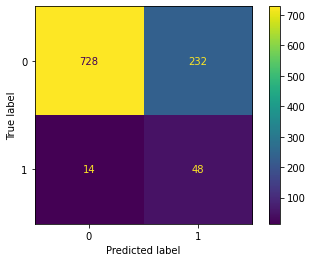

In [ ]:
plot_confusion_matrix(estimator=orig_model, X=test_data, y_true=test_labels)

In [ ]:
print(f'recall: {recall_score(test_labels, model.predict(test_data))}, {recall_score(test_labels, orig_model.predict(test_data))}')
print(f'precision: {precision_score(test_labels, model.predict(test_data))}, {precision_score(test_labels, orig_model.predict(test_data))}')
print(f'accuracy: {accuracy_score(test_labels, model.predict(test_data))}, {accuracy_score(test_labels, orig_model.predict(test_data))}')

recall: 1.0, 0.7741935483870968
precision: 0.09408194233687406, 0.17142857142857143
accuracy: 0.4158512720156556, 0.7592954990215264


Реализуем SVM (метод опорных векторов):

In [31]:
class SupportVectorMachine(BaseEstimator, ClassifierMixin):
    def __init__(
        self,  
        lr: float = 1e-3,
        C: float = 1.0,
        max_iter: int = 100
    ):
        self.C = C
        self.lr = lr
        self.max_iter = max_iter

    def fit(self, X, y):
        self.X_, self.y_ = check_X_y(X, y)
        self.labels = np.where(self.y_ == 0, -1, 1)
        w = np.random.normal(size=(self.X_.shape[1], ))
        b = 0.0
        for _ in range(self.max_iter):
            for i, obj in enumerate(self.X_):
                if self.labels[i] * (obj @ w + b) >= 1:
                    dw = w / self.C
                    db = 0
                else:
                    dw = w / self.C - self.labels[i] * obj
                    db = -self.labels[i]
                w -= self.lr * dw
                b -= self.lr * db
        self.w = w
        self.b = b
        return self

    def predict(self, X):
        return np.where(
            np.sign(np.dot(X, self.w) + self.b) == -1, 0, 1
        )

In [32]:
model = GridSearchCV(
    refit=True,
    scoring='accuracy',
    verbose=3,
    estimator=make_pipeline(
        ColumnTransformer(transformers=[
            ('categories', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 4, 5, 6, 9]),
            ('normalizer', StandardScaler(), [1, 7, 8])
        ]),
        SupportVectorMachine()
    ),
    param_grid={
        'supportvectormachine__lr': [1e-04, 1e-03, 1e-02],
        'supportvectormachine__C': [1e-1, 1.0, 10.0],
        'supportvectormachine__max_iter': [100, 200],
    },
    n_jobs=-1,
)
orig_model = GridSearchCV(
    refit=True,
    scoring='accuracy',
    verbose=3,
    estimator=make_pipeline(
        ColumnTransformer(transformers=[
            ('categories', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 4, 5, 6, 9]),
            ('normalizer', StandardScaler(), [1, 7, 8])
        ]),
        SVC()
    ),
    param_grid={
        "svc__C": [0.02, 0.1, 0.5],
        "svc__kernel": ["linear", "poly", "rbf"],
        "svc__tol": [1e-2, 5e-2],
    },
    n_jobs=-1,
)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


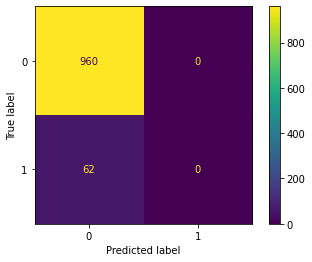

In [33]:
model.fit(train_data, train_labels)
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(model.best_estimator_, file)
plot_confusion_matrix(estimator=model, X=test_data, y_true=test_labels)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


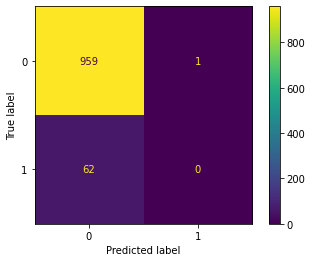

In [28]:
orig_model.fit(train_data, train_labels)
plot_confusion_matrix(estimator=orig_model, X=test_data, y_true=test_labels)

Реализуем Наивный Байес:

In [ ]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.unique_labels = np.unique(y)
        self.X_, self.y_ = X, y
        self.smooth = 1e-3 
        self.X_depends_on_Y = {} 
        for label in self.unique_labels:
            distributions = []
            for i in range(X.shape[1]):
                feature = X[y == label, i].flatten()
                distributions.append(scipy.stats.norm(loc=feature.mean(), scale=(feature.std() + self.smooth)))
            self.X_depends_on_Y[label] = distributions
        self.Y_probs = {label: sum((y == label)).astype(float) / len(y) for label in self.unique_labels}
    
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        probs = np.zeros((X.shape[0], len(self.unique_labels)), dtype=float)
        X_probs = np.ones((X.shape[0], len(self.unique_labels)), dtype=float)
        for i, label in enumerate(self.unique_labels):
            for j in range(X.shape[1]):
                probs[:, i] += np.log(self.X_depends_on_Y[label][j].pdf(X[:, j]) + self.smooth)
            probs[:, i] += np.log(self.Y_probs[label] + self.smooth)
        return np.array(probs.argmax(axis=1))

In [ ]:
model = GridSearchCV(
    refit=True,
    scoring='accuracy',
    verbose=3,
    estimator=make_pipeline(
        ColumnTransformer(transformers=[
            ('categories', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 4, 5, 6, 9]),
            ('normalizer', StandardScaler(), [1, 7, 8])
        ]),
        NaiveBayes()
    ),
    param_grid={},
    n_jobs=-1,
)

In [ ]:
orig_model = GridSearchCV(
    refit=True,
    scoring='accuracy',
    verbose=3,
    estimator=make_pipeline(
        ColumnTransformer(transformers=[
            ('categories', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 4, 5, 6, 9]),
            ('normalizer', StandardScaler(), [1, 7, 8])
        ]),
        GaussianNB()
    ),
    param_grid={},
    n_jobs=-1,    
)

In [ ]:
with open('logreg_model.pkl', 'rb') as file:
    model.best_estimator_ = pickle.load(file)

In [ ]:
model.fit(train_data, train_labels)
with open('bayes_model.pkl', 'wb') as file:
    pickle.dump(model.best_estimator_, file)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


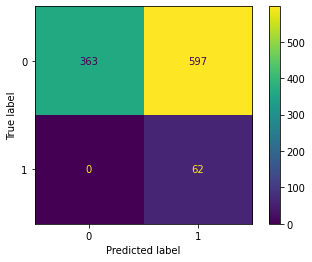

In [ ]:
plot_confusion_matrix(estimator=model, X=test_data, y_true=test_labels)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


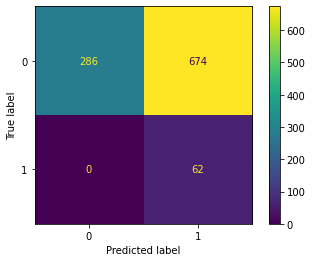

In [ ]:
orig_model.fit(train_data, train_labels)
plot_confusion_matrix(estimator=orig_model, X=test_data, y_true=test_labels)

In [ ]:
print(f'recall: {recall_score(test_labels, model.predict(test_data))}, {recall_score(test_labels, orig_model.predict(test_data))}')
print(f'precision: {precision_score(test_labels, model.predict(test_data))}, {precision_score(test_labels, orig_model.predict(test_data))}')
print(f'accuracy: {accuracy_score(test_labels, model.predict(test_data))}, {accuracy_score(test_labels, orig_model.predict(test_data))}')

recall: 1.0, 1.0
precision: 0.09408194233687406, 0.08423913043478261
accuracy: 0.4158512720156556, 0.3405088062622309


Алгоритм К-ближайших соседей:

In [17]:
class KNearestNeighbours(BaseEstimator, ClassifierMixin):
    def __init__(self,  
                 nearest: int = 5,
                 is_uniform: bool = True):
        self.nearest = nearest
        self.is_uniform = is_uniform
        self.EPS = 1e-08

    def fit(self, X, y):
         self.X_, self.y_ = check_X_y(X, y)
         self.unique_labels = np.unique(self.y_)
         return self

    def get_pred(self, nearest):
        preds = np.zeros(len(self.unique_labels))
        for d, i in nearest:
            preds[i] += 1.0 / (d + self.EPS) if not self.is_uniform else 1.0
        return np.argmax(preds)

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        preds = []
        for x in X:
            ds = []
            for i, v in enumerate(self.X_):
                d = np.linalg.norm(x - v)
                ds.append((d, self.y_[i]))
            ds.sort()
            nearest = ds[: self.nearest]
            preds.append(self.get_pred(nearest))
        return np.array(preds, dtype=int)

In [18]:
model = GridSearchCV(
    refit=True,
    scoring='accuracy',
    verbose=3,
    estimator=make_pipeline(
        ColumnTransformer(transformers=[
            ('categories', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 4, 5, 6, 9]),
            ('normalizer', StandardScaler(), [1, 7, 8])
        ]),
        KNearestNeighbours()
    ),
    param_grid={
        'knearestneighbours__nearest': [3, 4, 5, 8],
        'knearestneighbours__is_uniform': [False, True],
    },
    n_jobs=-1,
)
orig_model = GridSearchCV(
    refit=True,
    scoring='accuracy',
    verbose=3,
    estimator=make_pipeline(
        ColumnTransformer(transformers=[
            ('categories', OneHotEncoder(sparse=False, handle_unknown='ignore'), [0, 4, 5, 6, 9]),
            ('normalizer', StandardScaler(), [1, 7, 8])
        ]),
        KNeighborsClassifier()
    ),
    param_grid={
        'kneighborsclassifier__n_neighbors': [3, 4, 5, 8],
        'kneighborsclassifier__weights': ['uniform', 'distance'],
    },
    n_jobs=-1,
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


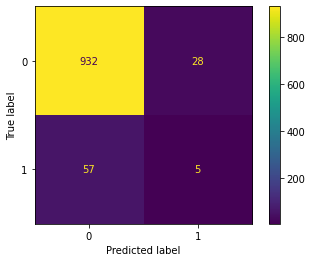

In [19]:
model.fit(train_data, train_labels)
with open('knn_model.pkl', 'wb') as file:
    pickle.dump(model.best_estimator_, file)
plot_confusion_matrix(estimator=model, X=test_data, y_true=test_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


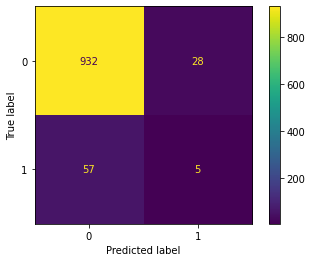

In [20]:
orig_model.fit(train_data, train_labels)
plot_confusion_matrix(estimator=orig_model, X=test_data, y_true=test_labels)

In [21]:
print(f'recall: {recall_score(test_labels, model.predict(test_data))}, {recall_score(test_labels, orig_model.predict(test_data))}')
print(f'precision: {precision_score(test_labels, model.predict(test_data))}, {precision_score(test_labels, orig_model.predict(test_data))}')
print(f'accuracy: {accuracy_score(test_labels, model.predict(test_data))}, {accuracy_score(test_labels, orig_model.predict(test_data))}')

recall: 0.08064516129032258, 0.08064516129032258
precision: 0.15151515151515152, 0.15151515151515152
accuracy: 0.9168297455968689, 0.9168297455968689
